In [3]:
import os
import codecs
import numpy.random as nr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
#import plotly_express as px

#bokeh for plotting
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#displaying numbers instead of scientific notation
pd.options.display.float_format = '{:.2f}'.format

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

#for creating wordcloud
from wordcloud import WordCloud, STOPWORDS


from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

#import bert
#from bert import run_classifier
#from bert import optimization
#from bert import tokenization

import re
import spacy

#initiate spacy with english language
#nlp = spacy.load('en_core_web_sm')
import en_core_web_sm
nlp = en_core_web_sm.load()
from pattern.en import suggest
import nltk

#phrase modeling
from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases , Phraser
import string
from nltk import pos_tag

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize
from gensim.models.word2vec import Text8Corpus
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import gensim
from gensim import corpora

#LDA Topic Modeling
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim
import warnings
import pickle

#dimensionality reduction - visualization
from sklearn.manifold import TSNE

Loading BokehJS ...

# Natural Language Processing With Customer Reviews

## Initial Steps
- __1. Import data__
- __2. Set the data frame up to contain only reviews__
- __3. Clean the text and extract dates for index column__

In [4]:

os.chdir('C:\\Users\\Sam Cannon\\Desktop\\MAAC\\NLP')

In [5]:
df = pd.read_csv('visit_survey.csv')

reviews = pd.DataFrame(df.iloc[:, 1]).dropna().rename(columns = {'Unnamed: 1':'reviews'}).reset_index(drop = True)

#cut out first few rows that don't hold any info
reviews = reviews.iloc[17:, :].reset_index(drop = True)

#extract dates from text and make them the index
# (?P<Date>....) - named capturing group
# \d+ 1 or more digits
# (?:\/\d+){2} - non-capturing group repeating twice, where
# \/ - escaped forward slash
# {2} - repeater (two times)
reviews.index = reviews.reviews.str.extract(r'(?P<Date>\d+(?:\/\d+){2})', expand=False).apply(pd.to_datetime)

#remove dates and symbols in date strings from reviews with regex, strip all white space
reviews['reviews'].replace(regex=True,inplace = True, to_replace=r'\d|/|-',value=r' ')

#strip all whitespace to the left of the text, created through removing dates from reviews
reviews['reviews'] = reviews.reviews.str.lstrip()

reviews.head()

,reviews
Date,
2018-07-03,Front desk and check out staff are not nearly as nice as the professionals in the back. Check out lady acts like she doesn?t want to wait on you.
2018-07-03,Complete attention & care. More than expected!!
2018-07-03,"My doctor, Dr. Walcott was very professional and kind. All the employees that took care of me were very professional and efficient"
2018-07-03,All is great
2018-07-03,"Dr Venarsky is outstanding, as well as the staff. I had an insurance question, and Nicki was so helpful. You guys are greatly appreciated."


## Generating A Wordcloud From Reviews
- __Here I am going to create an overall wordcloud to see what the most common words are from the reviews__
- __While this will show the common words, it will not reflect the negative reviews most likely since those are mentioned less, so I want to parse those out eventually using sentiment analysis__

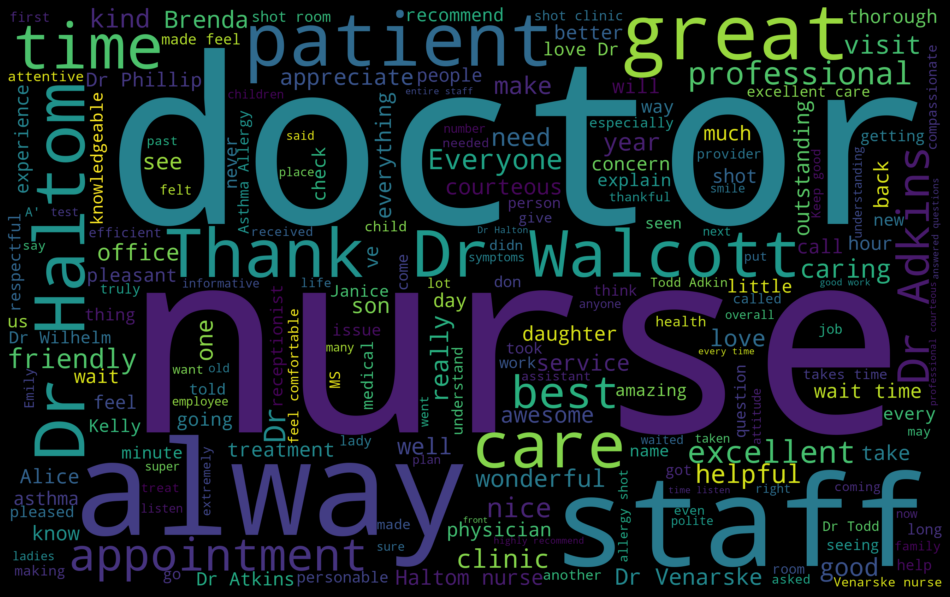

In [3]:
text = reviews.reviews.values
wordcloud = WordCloud(
    width = 2650,
    height = 1650,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (13, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();

## Phrase and Topic Modeling
- I want to try and make sure that the text that is being tokenized will include phrases that should belong together as single tokens. For example, if New York City is in the corpus somewhere, I want the token to be New_York_City since those words are not independent from each other, they should be treated as one phrase. 
- I will be using lemmatization, stop word removal, and punctuation removal
- Big help here: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [6]:
#get all reviews into list
data = list(reviews.reviews.values)

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [8]:
data_words = list(sent_to_words(data))

In [9]:
print(data_words[32])

['dr', 'haltom', 'has', 'been', 'one', 'of', 'my', 'he', 'best', 'drs', 'have', 'seen', 'to', 'keep', 'me', 'informed', 'of', 'test', 'results', 'and', 'outlook', 'would', 'highly', 'recommend', 'him', 'to', 'anyone']


Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [10]:
# Build the bigram and trigram models
#the min_count determines if the model ignores all words and bigrams with total collected count lower than this value.
bigram = gensim.models.Phrases(data_words, min_count=1, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], min_count = 1, threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See bigram example
print(trigram_mod[bigram_mod[data_words[32]]])

['dr', 'haltom', 'has', 'been', 'one', 'of', 'my', 'he', 'best', 'drs', 'have', 'seen', 'to', 'keep', 'me', 'informed', 'of', 'test_results', 'and', 'outlook', 'would', 'highly_recommend', 'him', 'to', 'anyone']


In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form trigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#see example of bigram
print(data_lemmatized[:1])

[['front_desk', 'check', 'staff', 'nearly', 'nice', 'professional', 'check', 'lady', 'act', 'want', 'wait']]


In [13]:
#take all of the lemmatized and trigrammed reviews and dump them into a new column
reviews['scrubbed_reviews'] = [x for x in data_lemmatized]

In [14]:
#convert column of lists to strings
reviews['scrubbed_reviews'] = reviews['scrubbed_reviews'].apply(', '.join)

#remove commas from strings
reviews['scrubbed_reviews'] = reviews['scrubbed_reviews'].str.replace(',','')


You can see that the phraser model has successfully modeled bigrams as words that belong together such as "allergy shot" and "front desk"

In [15]:
#looking at reviews that contain bigrams
reviews[reviews['scrubbed_reviews'].str.contains('_')].tail(10)

,reviews,scrubbed_reviews
Date,,
2019-11-22,"Dr. Venarske was excellent. Professional, knowledgeable and has a great bedside manner! I would definitely recommend him.",excellent professional knowledgeable great bedside_manner definitely_recommend
2019-11-23,Don’t care for the layout of the waiting room. I felt we were too close together. My doctor was running way behind and I was there over hours and I saw the doctor for minutes!,care layout waiting_room feel close together doctor run way hour see doctor minute
2019-12-04,Ms. Brenda is great. I appreciate her helping me to get some much needed nasal spray. Thank you Ms. Brenda for always having a beautiful smile and a beautiful attitude.,great appreciate help much need nasal_spray thank always beautiful smile beautiful attitude
2019-12-27,The wait time on phone to make or cancel is way to long! I waited over minutes to cancel my apt and had to hang up to catch a work call! I called back several times to cancel and the same thing took place!,wait time phone make cancel way long wait minute cancel work call called_back several time cancel thing take place
2020-01-01,"Dr. Walcott is always very personable, attentive and thorough. I highly recommend him to my friends.",always personable attentive thorough highly_recommend friend
2020-01-02,"My son's issues were addressed & I am very confident that everything is going to be resolved now! Also, the doctor was VERY thorough with examination! Would HIGHLY RECOMMEND",issue address confident go resolve also doctor thorough examination highly_recommend
2020-01-08,"Dr. Vernarske and all his staff are fantastic medical care providers,, from giving me allergy shots to helping me manage my allergies and newly diagnosed asthma! I feel I am getting treatment from the best! John Apidaca",vernarske staff fantastic medical care provider give allergy_shot help manage allergy newly diagnose asthma feel get treatment good
2020-01-07,"Dr. Chelle Wilhelm is not only efficient at diagnosing your issues but she follows through in concern what changes you may have, if any and access what is best going forward. She's very pleasant and respectful, a great listener to your concerns. She's easy to reach and the staff is respectful and courteous and make sure your messages get to her if she's in clinic or out of the office. I'm pleased with overall service.",diagnosing issue follow concern change access good go forward pleasant respectful great listener concern easy reach staff respectful courteous make_sure message get clinic office please overall service
2020-01-08,"Dr. Wilhelm was excellent I loved her bedside manner, she was pleasant as easy to talk to, she explained her plan of care and didn’t force her treatments on you she allowed me to decide how I wanted my treatment to be carried out, I will definitely recommend her and her nurse was excellent also..",excellent loved bedside_manner pleasant easy talk explain plan care force treatment allow decide want treatment carry nurse excellent also


In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


Consider using LDA Mallet model in the future

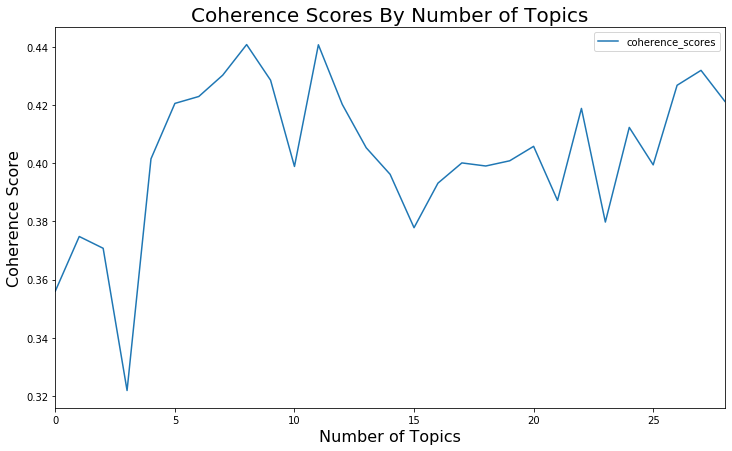

In [23]:
#how many topics should we have? We can use coherence scores to see which number of topics gives us the highest score, and use that in our final model
# Build LDA model
num_topics = list(range(1, 30))
models = []
for topic in num_topics:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=topic, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    models.append(lda_model)
    
# Compute Coherence Score
coherence_scores = []
for model in models:
    coherence_model_lda = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_scores.append(coherence_model_lda.get_coherence())

#plot coherence scores and see which one makes the most sense (looks like 8 is the best)
pd.DataFrame(coherence_scores).rename(columns = {0:'coherence_scores'}).plot(figsize = (12, 7))
plt.ylabel('Coherence Score', fontsize = 16)
plt.xlabel('Number of Topics', fontsize = 16)
plt.title('Coherence Scores By Number of Topics', fontsize = 20);

In [24]:
#double check our topic number -- so we should use 8 topics
pd.DataFrame(coherence_scores).idxmax()

0    8
dtype: int64

In [29]:
# Build LDA model with 8 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [30]:
# Print the Keyword in the topics
lda_model.print_topics()
doc_lda = lda_model[corpus]

[(0,
  '0.053*"question" + 0.051*"really" + 0.045*"answer" + 0.033*"time" + 0.028*"personable" + 0.025*"ask" + 0.023*"patient" + 0.018*"say" + 0.017*"tell" + 0.015*"call"'),
 (1,
  '0.022*"clinic" + 0.021*"receive" + 0.020*"call" + 0.020*"shot" + 0.019*"back" + 0.017*"entire" + 0.017*"people" + 0.016*"sick" + 0.015*"prescription" + 0.014*"hear"'),
 (2,
  '0.049*"kind" + 0.022*"employee" + 0.020*"phone" + 0.020*"greet" + 0.019*"compassionate" + 0.018*"solution" + 0.016*"provide" + 0.016*"friend" + 0.016*"seem" + 0.015*"concerned"'),
 (3,
  '0.047*"experience" + 0.035*"office" + 0.027*"keep" + 0.026*"ever" + 0.021*"name" + 0.019*"allergy_shot" + 0.019*"overall" + 0.019*"respectful" + 0.017*"clean" + 0.015*"make_sure"'),
 (4,
  '0.055*"nurse" + 0.046*"doctor" + 0.044*"great" + 0.041*"care" + 0.038*"good" + 0.030*"time" + 0.027*"staff" + 0.026*"wait" + 0.026*"patient" + 0.024*"adkin"'),
 (5,
  '0.071*"make" + 0.050*"feel" + 0.033*"appointment" + 0.032*"awesome" + 0.023*"issue" + 0.017*"pla

In [31]:
# # Compute Perplexity
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)

In [32]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

26.83  2.41     -2.98   
187   Topic6  6.58    next             7.28   2.39     -4.31   
739   Topic6  6.13    form             6.82   2.38     -4.38   
104   Topic6  5.61    rush             6.31   2.37     -4.47   
1111  Topic6  5.27    message          5.97   2.36     -4.53   
639   Topic6  5.01    none             5.70   2.36     -4.58   
177   Topic6  4.87    test             5.57   2.36     -4.61   
416   Topic6  4.75    listener         5.45   2.35     -4.64   
202   Topic6  4.73    bedside_manner   5.43   2.35     -4.64   
440   Topic6  4.57    exactly          5.26   2.35     -4.67   
175   Topic6  4.44    right            5.14   2.34     -4.70   
1113  Topic6  4.22    ready            4.91   2.34     -4.75   
524   Topic6  3.92    actually         4.61   2.33     -4.83   
832   Topic6  3.51    away             4.21   2.31     -4.94   
1205  Topic6  3.21    lovable          3.90   2.29     -5.03   
282   Topic6  3.02    wish             3.71   2.28     -5.09   
285   Topic6  2.84    wife             3.54   2.27     -5.15   
419   Topic6  2.48    add              3.18   2.24     -5.28   
107   Topic6  21.82   answer           28.09  2.24     -3.11   
746   Topic6  2.34    part             3.03   2.23     -5.34   
859   Topic6  2.23    made_sure        2.92   2.22     -5.39   
1114  Topic6  2.15    realize          2.85   2.21     -5.43   
1106  Topic6  2.15    end              2.85   2.21     -5.43   
441   Topic6  2.04    fit              2.73   2.19     -5.48   
654   Topic6  2.00    level            2.70   2.19     -5.50   
183   Topic6  1.94    spend            2.64   2.18     -5.53   
932   Topic6  1.90    idea             2.59   2.18     -5.55   
188   Topic6  8.77    say              13.13  2.08     -4.02   
143   Topic6  8.24    tell             12.55  2.07     -4.08   
315   Topic6  4.66    place            7.50   2.01     -4.65   
106   Topic6  5.69    thing            9.63   1.96     -4.45   
459   Topic6  6.26    people           15.31  1.59     -4.36   
203   Topic6  7.35    call             21.73  1.40     -4.20   
67    Topic6  16.32   time             99.08  0.69     -3.40   
57    Topic6  11.03   patient          72.99  0.60     -3.79   
281   Topic6  3.46    team             6.88   1.80     -4.95   
173   Topic6  4.34    back             14.67  1.27     -4.73   
34    Topic6  3.54    issue            16.47  0.95     -4.93   
15    Topic7  7.76    employee         8.46   2.73     -3.81   
208   Topic7  7.15    phone            7.86   2.73     -3.89   
266   Topic7  7.10    greet            7.81   2.73     -3.90   
271   Topic7  6.72    compassionate    7.43   2.72     -3.95   
969   Topic7  6.21    solution         6.92   2.71     -4.03   
191   Topic7  5.66    provide          6.37   2.70     -4.13   
190   Topic7  5.51    friend           6.21   2.70     -4.15   
272   Topic7  5.27    concerned        5.98   2.70     -4.20   
909   Topic7  4.90    thoughtful       5.60   2.69     -4.27   
615   Topic7  4.76    checkout         5.46   2.68     -4.30   
624   Topic7  4.08    bless            4.79   2.66     -4.45   
269   Topic7  3.70    rather           4.40   2.65     -4.55   
616   Topic7  3.59    process          4.29   2.64     -4.58   
948   Topic7  3.49    possible         4.19   2.64     -4.61   
959   Topic7  3.48    serve            4.19   2.64     -4.61   
205   Topic7  4.33    leave            5.26   2.63     -4.39   
415   Topic7  3.19    knowledge        3.90   2.62     -4.70   
452   Topic7  2.97    instead          3.68   2.61     -4.77   
560   Topic7  2.85    sinus            3.56   2.60     -4.81   
1222  Topic7  2.81    wellbeing        3.51   2.60     -4.83   
1197  Topic7  2.81    profession       3.51   2.60     -4.83   
1196  Topic7  2.81    approach         3.51   2.60     -4.83   
1195  Topic7  2.81    fine             3.51   2.60     -4.83   
1194  Topic7  2.81    average          3.51   2.60     -4.83   
403   Topic7  2.75    indicate         3.46   2.59     -4.85   
868   T

### Further Visualization Strategies for Topic Modeling (static)
- https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

# Cluster Word Embeddings Using Word2Vec
- training for more epochs would probably give better results

In [33]:
# initiate the model and perform the first epoch of training, use our lemmatized data corpus (list of lists of tokens)
reviews2vec = Word2Vec(data_lemmatized, size=100, window=5,
                        min_count=1, sg=1, workers=3)
reviews2vec.save('word_vector_model.pkl')
# perform another 11 epochs of training
for i in range(1,12):
    reviews2vec.train(data_lemmatized, total_examples = reviews2vec.corpus_count, epochs = reviews2vec.epochs);
    reviews2vec.save('word_vector_model.pkl');
    
# Precompute L2-normalized vectors.
# If replace is set, forget the original vectors and only keep the normalized ones = saves lots of memory!
# Note that you cannot continue training after doing a replace. The model becomes effectively read-only = you can call most_similar, similarity etc., but not train.
reviews2vec = Word2Vec.load('word_vector_model.pkl');
reviews2vec.init_sims();

#check number of terms in dictionary
print(f'{len(reviews2vec.wv.vocab)} terms in the reviews2vec vocabulary.');

1233 terms in the reviews2vec vocabulary.


In [34]:
# build a list of the terms, integer indices,
# and term counts from the reviews2vec model vocabulary
ordered_vocab = [(term, voc.index, voc.count) for term, voc in reviews2vec.wv.vocab.items()]


#sorts list of tuples by n element (I needed to sort by the third element per tuple since it was word count)
def Sort_Tuple(tup):  
  
    reverse = None #(Sorts in Ascending order)  
    # key is set to sort using second element of  
    # sublist lambda has been used  
    tup.sort(key = lambda x: x[1])  
    return tup  
  
# printing the sorted list of tuples 
sorted_words = Sort_Tuple(ordered_vocab)

# # sort by the term counts, so the most common terms appear first
# ordered_vocab = sorted(ordered_vocab, key=lambda (term, index, count): -count)

# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

# create a DataFrame with the reviews2vec vectors as data,
# and the terms as row labels (gotta add .wv. to word2vec calls)
word_vectors = pd.DataFrame(reviews2vec.wv.syn0norm[term_indices, :],
                            index=ordered_terms)

word_vectors.head()

C:\Users\Sam Cannon\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
nurse,0.12,0.03,0.12,-0.18,-0.13,0.14,-0.10,-0.03,0.03,-0.10,-0.04,0.01,-0.12,-0.12,0.03,0.10,-0.15,-0.05,-0.00,0.21,-0.10,-0.05,0.08,0.06,-0.11,0.04,-0.08,-0.12,-0.01,0.04,-0.00,-0.05,-0.16,0.02,0.19,0.02,0.24,-0.05,0.04,0.06,-0.11,0.01,0.14,-0.11,0.23,0.16,0.08,0.05,0.18,0.03,0.02,-0.07,-0.13,0.02,-0.12,-0.21,-0.11,-0.04,0.11,0.01,0.15,0.04,-0.01,0.04,0.06,-0.16,-0.06,0.04,-0.03,0.02,-0.05,-0.10,0.02,-0.08,0.15,0.04,-0.07,0.03,-0.06,0.05,-0.09,-0.12,0.02,0.03,-0.08,0.05,-0.11,-0.11,-0.11,0.14,0.03,-0.10,-0.22,0.09,-0.01,-0.15,-0.02,-0.10,-0.01,0.03
time,-0.05,0.05,-0.06,-0.02,0.07,0.07,-0.15,0.15,0.09,-0.12,-0.04,0.04,0.03,-0.09,-0.11,0.04,0.09,0.08,0.01,0.08,-0.17,-0.23,0.03,0.11,-0.14,-0.01,-0.07,0.02,-0.18,0.13,0.01,0.07,0.10,-0.14,-0.09,0.03,0.07,0.08,0.05,0.10,-0.09,0.04,-0.10,-0.01,-0.00,-0.10,-0.02,-0.08,0.31,-0.04,0.04,0.12,-0.09,-0.01,-0.18,-0.19,-0.03,0.09,-0.05,-0.17,0.10,-0.13,0.05,-0.15,0.01,-0.01,0.03,0.12,-0.03,0.07,-0.15,-0.04,0.17,0.05,0.14,0.16,-0.16,-0.13,0.02,0.03,0.07,0.06,-0.01,-0.04,0.01,0.02,0.10,-0.02,0.04,-0.01,0.06,0.09,-0.10,0.21,-0.05,-0.12,0.11,0.00,0.17,-0.04
doctor,0.09,-0.04,0.05,-0.09,-0.02,0.08,-0.21,-0.04,-0.03,-0.20,-0.11,0.01,0.02,-0.06,-0.03,-0.01,-0.07,0.05,0.00,0.16,-0.20,-0.13,0.00,0.09,-0.14,-0.03,-0.05,-0.05,-0.28,0.07,-0.01,0.06,-0.03,-0.06,0.14,0.05,0.06,-0.21,0.12,0.04,-0.19,-0.15,0.02,-0.03,0.06,0.05,0.07,0.04,0.25,0.06,0.08,0.18,-0.17,0.11,-0.17,-0.08,-0.06,-0.04,0.02,0.02,0.13,-0.05,-0.16,-0.11,0.11,-0.01,0.08,0.04,0.06,-0.00,-0.10,-0.01,-0.10,-0.07,-0.05,0.03,-0.05,-0.02,-0.09,-0.18,0.00,-0.08,0.09,-0.01,0.01,0.09,0.12,-0.02,-0.12,0.17,-0.09,-0.02,-0.09,0.04,-0.02,-0.19,0.08,0.06,0.04,-0.06
care,-0.10,0.00,0.08,-0.17,0.04,0.02,-0.07,-0.05,0.08,-0.16,0.06,-0.16,-0.14,-0.15,0.02,0.07,-0.00,-0.09,-0.00,0.19,-0.04,0.01,-0.03,0.07,-0.07,0.04,-0.24,-0.10,-0.30,0.02,-0.14,-0.08,-0.06,-0.09,0.09,0.00,0.15,-0.01,-0.01,0.06,-0.15,0.10,-0.05,0.03,0.20,0.03,-0.01,0.01,0.10,-0.08,0.03,-0.12,-0.09,0.16,-0.16,-0.10,-0.02,0.02,0.03,0.00,0.14,-0.02,-0.11,-0.02,0.05,-0.05,0.02,0.03,0.01,0.08,0.09,-0.12,0.13,-0.10,0.27,0.11,-0.04,0.08,-0.00,0.03,0.01,-0.06,-0.01,0.04,0.04,0.04,-0.08,-0.08,-0.10,0.15,-0.05,-0.06,-0.05,0.12,-0.05,0.09,0.16,-0.21,0.13,0.02
always,0.01,0.11,-0.01,-0.11,0.05,-0.04,-0.09,0.10,0.18,-0.04,-0.10,0.07,0.03,-0.09,-0.12,0.04,-0.14,-0.10,0.06,0.14,0.05,-0.06,0.03,-0.05,-0.15,0.02,-0.05,-0.01,-0.13,-0.07,-0.12,-0.02,-0.12,0.02,0.03,0.06,0.12,-0.08,0.01,-0.06,-0.15,-0.00,0.02,-0.06,0.10,0.08,0.02,0.07,0.36,-0.09,0.03,-0.05,-0.19,-0.05,-0.00,-0.21,0.03,-0.04,0.14,0.10,0.15,-0.12,-0.08,0.02,0.08,-0.15,-0.02,0.01,-0.03,0.01,-0.20,-0.02,0.04,-0.10,0.21,0.13,0.08,-0.01,-0.13,0.00,-0.13,0.00,0.03,0.05,0.06,0.07,0.07,-0.02,-0.14,0.15,0.06,-0.06,-0.18,0.11,-0.05,-0.14,0.10,-0.08,0.12,0.14


In [35]:
def get_related_terms(token, topn=10):
    """
    look up the topn most similar terms to token
    and print them as a formatted list
    """

    for word, similarity in reviews2vec.most_similar(positive=[token], topn=topn):

        print(u'{:20} {}'.format(word, round(similarity, 3)))

In [36]:
#see related words
get_related_terms('nurse')

anywhere_else        0.813
glenda               0.806
everytime            0.798
dream                0.79
varnske              0.775
consider             0.768
exacerbated          0.765
competent            0.759
loved                0.758
hire                 0.758
C:\Users\Sam Cannon\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys


In [42]:
#reducing the dimensionality of the data to two columns for visualization using tsne
tsne = TSNE()
tsne_vectors = tsne.fit_transform(word_vectors.values)

tsne_vectors = pd.DataFrame(tsne_vectors,
                            index=pd.Index(word_vectors.index),
                            columns=[u'x_coord', u'y_coord'])

In [43]:
tsne_vectors.head()

,x_coord,y_coord
nurse,-8.10,9.74
time,-28.00,17.27
doctor,-4.07,3.25
care,-15.94,25.45
always,0.21,13.03


In [759]:
#creating column for words
tsne_vectors[u'word'] = tsne_vectors.index

In [760]:
tsne_vectors.head()

,x_coord,y_coord,word
nurse,21.34,28.21,nurse
time,16.32,-43.12,time
doctor,37.67,15.23,doctor
care,4.22,30.22,care
staff,9.49,13.93,staff


In [763]:
# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

# Using ELMo Word Vectors 

In [42]:
import mxnet as mx
from mxnet import gluon
import gluonnlp as nlp
nlp.utils.check_version('0.7.0')

In [68]:
import csv
elmo_file = 'text.txt'
with open(elmo_file, 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows([x for x in reviews.scrubbed_reviews])

In [69]:
dataset = nlp.data.TextLineDataset(elmo_file, 'utf8')
print(len(dataset))
print(dataset[3])

1288



In [76]:
a = [x.replace('.', ',') for x in [x for x in reviews.scrubbed_reviews]]

In [77]:
a[:10]

['front_desk check staff nearly nice professional check lady act want wait',
 'complete attention care expect',
 'professional kind employee take care professional efficient',
 'great',
 'outstanding well staff insurance question helpful guy greatly_appreciate',
 'love',
 'make daughter feel comfortable ease also great communicating issue highly_recommend',
 'clinic',
 'doctor several_year staff always courteous professional highly_recommend',
 'find feel first day meet go care well smart professional truly_care patient meet physician state good specialist field practice totally agree staff always polite courteous appreciate fact time go appointment wait lobby long great customer patient service thank thank sincerely beverly funche']

# Getting Word Vectors With Fasttext
- on dimensionality size "That is, the embedding vector dimension should be the 4th root of the number of categories. Since our vocabulary size in this example is 81, the recommended number of dimensions is 3:"
- According to Google -> https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html

- BUT they follow that up with "Note that this is just a general guideline; you can set the number of embedding dimensions as you please." FYI
- Play around and see essentially lol

In [17]:
from gensim.models import FastText
#the parameter "sg" indicates usage of the skipgram model, otherwise cbow is used as default
fasttext_vectors = FastText(data_lemmatized, size=6, window=5, min_count=1, workers=4, sg=1)

In [18]:
#this is another way to train the FastText model, using multiple steps, the documentation states that the single line method I used above is 
# depracated, but it seems to work fine for now... I made this a CBOW model btw to check against skipgram
model = FastText(size = 6, window = 3, min_count = 1)
model.build_vocab(sentences = data_lemmatized)
model.train(sentences = data_lemmatized, total_examples = len(data_lemmatized), epochs = 10)

In [19]:
len(model.wv.vocab)

1233

In [20]:
len(fasttext_vectors.wv.vocab)

1233

In [22]:
#what words are most similar to doctor?
fasttext_vectors.wv.most_similar("nurse")

[('point', 0.9999750256538391),
 ('annually', 0.9999557137489319),
 ('co', 0.9999533891677856),
 ('recording', 0.9999432563781738),
 ('experience', 0.9999357461929321),
 ('quickly', 0.9999335408210754),
 ('teammate', 0.9999274015426636),
 ('usually', 0.99992436170578),
 ('sure', 0.9999006986618042),
 ('personality', 0.9998974204063416)]

In [23]:
model.wv.most_similar('nurse')

[('annually', 0.999974250793457),
 ('point', 0.9999707341194153),
 ('experience', 0.9999662637710571),
 ('usually', 0.9999526739120483),
 ('ever', 0.9999526143074036),
 ('personality', 0.9999494552612305),
 ('incredible', 0.9999489784240723),
 ('especially', 0.9999425411224365),
 ('aformentione', 0.9999394416809082),
 ('experienced', 0.9999387264251709)]

In [117]:
# build a list of the terms, integer indices,
# and term counts from the fasttext model vocabulary
ordered_vocab = [(term, voc.index, voc.count) for term, voc in fasttext_vectors.wv.vocab.items()]


#sorts list of tuples by n element (I needed to sort by the third element per tuple since it was word count)
def Sort_Tuple(tup):  
  
    reverse = None #(Sorts in Ascending order)  
    # key is set to sort using second element of  
    # sublist lambda has been used  
    tup.sort(key = lambda x: x[1])  
    return tup  
  
# printing the sorted list of tuples 
sorted_words = Sort_Tuple(ordered_vocab)

# # sort by the term counts, so the most common terms appear first
# ordered_vocab = sorted(ordered_vocab, key=lambda (term, index, count): -count)

# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

# create a DataFrame with the reviews2vec vectors as data,
# and the terms as row labels 
word_vectors = pd.DataFrame(fasttext_vectors.wv.vectors[term_indices, :],
                            index=ordered_terms)

word_vectors.head()

,0,1,2,3,4,5
nurse,-0.17,-0.74,-1.07,-0.75,0.69,0.07
time,-0.27,-0.82,-1.14,-0.83,0.78,0.09
doctor,-0.18,-0.76,-1.11,-0.81,0.71,0.10
care,-0.25,-0.83,-1.26,-0.95,0.78,0.07
always,-0.16,-0.64,-0.99,-0.72,0.64,0.07


In [118]:
#reducing the dimensionality of the data to two columns for visualization using tsne
tsne = TSNE()
tsne_vectors = tsne.fit_transform(word_vectors.values)

tsne_vectors = pd.DataFrame(tsne_vectors,
                            index=pd.Index(word_vectors.index),
                            columns=[u'x_coord', u'y_coord'])


#creating column for words
tsne_vectors[u'word'] = tsne_vectors.index

# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

In [24]:
# build a list of the terms, integer indices,
# and term counts from the fasttext model vocabulary
ordered_vocab = [(term, voc.index, voc.count) for term, voc in model.wv.vocab.items()]


#sorts list of tuples by n element (I needed to sort by the third element per tuple since it was word count)
def Sort_Tuple(tup):  
  
    reverse = None #(Sorts in Ascending order)  
    # key is set to sort using second element of  
    # sublist lambda has been used  
    tup.sort(key = lambda x: x[1])  
    return tup  
  
# printing the sorted list of tuples 
sorted_words = Sort_Tuple(ordered_vocab)

# # sort by the term counts, so the most common terms appear first
# ordered_vocab = sorted(ordered_vocab, key=lambda (term, index, count): -count)

# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

# create a DataFrame with the reviews2vec vectors as data,
# and the terms as row labels 
word_vectors = pd.DataFrame(model.wv.vectors[term_indices, :],
                            index=ordered_terms)

#reducing the dimensionality of the data to two columns for visualization using tsne
tsne = TSNE()
tsne_vectors = tsne.fit_transform(word_vectors.values)

tsne_vectors = pd.DataFrame(tsne_vectors,
                            index=pd.Index(word_vectors.index),
                            columns=[u'x_coord', u'y_coord'])


#creating column for words
tsne_vectors[u'word'] = tsne_vectors.index

# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

This is another way to train a model, and then expose several functionalities from it
https://github.com/facebookresearch/fastText/tree/master/python#text-classification-model


In [31]:
import fasttext
cbow_model = fasttext.train_unsupervised('text.txt', model = 'cbow', dim = 6, epoch = 10, minCount = 1)

In [22]:
skip_model = fasttext.train_unsupervised('text.txt', model = 'skipgram')

In [32]:
print(cbow_model['nurse'])

[-0.2505613  -0.04907143  0.05734102 -0.5210561  -0.07288691  0.17796049]


In [35]:
#get vector representation for a sentence
cbow_model.get_sentence_vector('I loved this place it was awesome')

array([-0.25394976, -0.01262465,  0.07123998, -0.83392173, -0.20753847,
        0.17194848], dtype=float32)

In [41]:
print(cbow_model['nurse'])

[-0.2505613  -0.04907143  0.05734102 -0.5210561  -0.07288691  0.17796049]


In [42]:
cbow_model.get_word_vector('nurse')

array([-0.2505613 , -0.04907143,  0.05734102, -0.5210561 , -0.07288691,
        0.17796049], dtype=float32)

In [47]:
#get full df with all word vectors, I can then use this with t-sne
words = []
for word in cbow_model.get_words():
    words.append(cbow_model.get_word_vector(word))

word_vector_df = pd.DataFrame(words, index = cbow_model.get_words())

In [48]:
word_vector_df

,0,1,2,3,4,5
</s>,-0.282058,0.096209,-0.075082,-0.359369,0.030699,0.119686
nurse,-0.250561,-0.049071,0.057341,-0.521056,-0.072887,0.177960
time,-0.224307,-0.003693,0.033017,-0.513715,-0.072547,0.148537
doctor,-0.144484,-0.071543,0.050683,-0.354010,-0.004387,0.113220
care,-0.437714,-0.119930,0.060765,-0.930686,-0.165671,0.263956
...,...,...,...,...,...,...
tissue,-0.106233,-0.002592,0.038928,-0.179790,-0.017050,0.075151
coordinator,-0.089484,-0.031557,0.025690,-0.237294,-0.018657,0.083549
verification,-0.373689,-0.082185,0.052876,-0.858613,-0.127428,0.266386
clerk,-0.092436,-0.024197,0.042110,-0.213067,-0.009568,0.053058


# Vectorizing Reviews with Doc2Vec

In [62]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [63]:
reviews = pd.read_csv('text.txt', header = None)

In [66]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews[0])]

In [68]:
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [69]:
model

In [72]:
print(documents)

s provide solution tip', tags=[423]), TaggedDocument(words='thank', tags=[424]), TaggedDocument(words='professional courteous staff however person give shot need pinch fatty portion arm administer shoot prior allergist rarely discomfort yesterday give shot arm low muscle area arm morning sign', tags=[425]), TaggedDocument(words='excellent understand importance good customer_service', tags=[426]), TaggedDocument(words='adkin great answer question explain test take away anxiety concern', tags=[427]), TaggedDocument(words='none time', tags=[428]), TaggedDocument(words='patient wait get allergy shot always pleasant courteous', tags=[429]), TaggedDocument(words='assistant always kind beat professional haltom best always nice', tags=[430]), TaggedDocument(words='doctor nurse great lady pleasure see super concerned health', tags=[431]), TaggedDocument(words='adkin always awesome make son feel comfortable calm nerve nurse awesome respectful assure son ok scared nervous patient', tags=[432]), T

In [75]:
len(documents)

606

In [100]:
#getting document vectors
vectorized_reviews = pd.DataFrame([model.docvecs[x] for x in list(range(0,606,1))], index = reviews[0])

In [105]:
#reducing the dimensionality of the data to two columns for visualization using tsne
tsne = TSNE()
tsne_vectors = tsne.fit_transform(vectorized_reviews.values)

tsne_vectors = pd.DataFrame(tsne_vectors,
                            index=pd.Index(vectorized_reviews.index),
                            columns=[u'x_coord', u'y_coord'])


#creating column for words
tsne_vectors[u'word'] = tsne_vectors.index

# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Entire Review Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);